# ウェブサービスにおけるデータサイエンス実践 第7回

## 機械学習の利用・評価・改善

## 今日の目的

- 機械学習を実際に用いる流れについて理解する
- 適切な実験設定を選んで実行できるようになる
- 過学習について理解し、正規化の有効性を知る
- パラメータチューニングができる


## 内容

- 機械学習の利用プロセス
    - train, valid, test分割
    - n-fold cross validation
    - underfit, overfitとその対策
    - 様々な評価指標の特徴と取捨選択

  
## やらないこと

- アルゴリズムの詳細な理論、比較
- モデルの改善のための特徴量エンジニアリング

In [1]:
%matplotlib inline

import pandas
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_curve

## 使うデータセット

- Titanic
  - https://www.kaggle.com/c/titanic/overview
- タイタニックで生存する人を予測するタスク
- 機械学習コミュニティでよく使われる伝統的なデータセット


## 参考資料

- https://www.kaggle.com/vinayshaw/for-beginner-titanic-model-eda-90-accuracy

In [2]:
df_train = pandas.read_csv('../resources/titanic/train.csv')
df_test = pandas.read_csv('../resources/titanic/test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## データセットの構成

- passenger-ID : 乗客ID
- survived: 生存したかどうか
- Pclass: 何等客室か？ 
- Name: 名前
- sex: 性別
- Age: 年齢
- SibSp: 載っている兄弟・配偶者の数
- Parch: のっている親・子の数
- Ticket: Ticket number
- Fare: 運賃
- Cabin: 部屋番号
- Embarked: 乗船港

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


- 891人分の訓練データがある
- テストデータは418人分
- 訓練、テスト共に年齢が一部欠損している、
- Cabinは欠損が多い。

## 欠損値処理

- 年齢とFareはMedianを埋めよう
- Cabinはよくわからないので、今回は使わないでおこう
- EmbarkedがNullのデータはテストにないので、EmbarkedがNullのデータを抜いてしまおう


(本当はもう少しちゃんとしたほうが精度あがるけど、今日は精度を上げるのが目的ではないので)

In [7]:
df_train['Age'].fillna(df_train['Age'].median(),inplace=True)
df_test['Age'].fillna(df_train['Age'].median(),inplace=True)

In [8]:
df_test['Fare'].fillna(df_train['Fare'].median(),inplace=True)

In [9]:
# Cabinを消す
del df_train['Cabin']
del df_test['Cabin']

In [10]:
# EmbarkedがNullのユーザを削除
df_train = df_train[~df_train['Embarked'].isnull()]

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 32.8+ KB


## 機械学習させやすいデータにする

- Pclassは1, 2, 3だが、離散値でありカテゴリとしての意味が強いのでカテゴリカルな変数とする
- Sexも同様
- Name, Ticket, PassengerIdは使いづらいので削除
- Embarkedもカテゴリにする

(本当はもう少しちゃんとしたほうが精度あがるけど、今日は精度を上げるのが目的ではないので)

In [13]:
df_train = pandas.concat([df_train, pandas.get_dummies(df_train['Sex'])], axis=1)

In [14]:
df_test = pandas.concat([df_test, pandas.get_dummies(df_test['Sex'])], axis=1)

In [15]:
df_train = pandas.concat([df_train, pandas.get_dummies(df_train['Pclass'], prefix='Pclass')], axis=1)

In [16]:
df_test = pandas.concat([df_test, pandas.get_dummies(df_test['Pclass'], prefix='Pclass')], axis=1)

In [17]:
df_train = pandas.concat([df_train, pandas.get_dummies(df_train['Embarked'], prefix='Embarked')], axis=1)
df_test = pandas.concat([df_test, pandas.get_dummies(df_test['Embarked'], prefix='Embarked')], axis=1)

In [18]:
del df_train['Ticket'], df_test['Ticket']

In [19]:
del df_train['Name'], df_test['Name']

In [20]:
del df_train["PassengerId"], df_test["PassengerId"]

In [21]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,3,male,22.0,1,0,7.2500,S,0,1,0,0,1,0,0,1
1,1,1,female,38.0,1,0,71.2833,C,1,0,1,0,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,S,1,0,0,0,1,0,0,1
3,1,1,female,35.0,1,0,53.1000,S,1,0,1,0,0,0,0,1
4,0,3,male,35.0,0,0,8.0500,S,0,1,0,0,1,0,0,1


In [22]:
df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,3,male,34.5,0,0,7.8292,Q,0,1,0,0,1,0,1,0
1,3,female,47.0,1,0,7.0000,S,1,0,0,0,1,0,0,1
2,2,male,62.0,0,0,9.6875,Q,0,1,0,1,0,0,1,0
3,3,male,27.0,0,0,8.6625,S,0,1,0,0,1,0,0,1
4,3,female,22.0,1,1,12.2875,S,1,0,0,0,1,0,0,1


## 機械学習モデルを作ろう

- TestはKaggleに提出するためのもので僕たちはその正解をしらない
- Trainでうまく学習していいモデルを作って、Testでも正解をしたい
- 良いモデルとはなにか？というために適切に評価をしなくてはならない。
- Cross-Validationをやる
    - Trainの一部を評価用データ（Valid）として用いる

In [23]:
features = ['Age', 'SibSp', 'Parch', 'Fare', 'female', 'male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

In [24]:
y = df_train['Survived'].astype(int)

In [25]:
X = df_train[features]

In [26]:
# TrainとVaidにわける
X_train,X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=624)

In [27]:
# 正規化なしのモデル
clf_nonreg = LogisticRegression(solver='lbfgs', penalty='none', max_iter=400)

In [28]:
clf_nonreg.fit(X_train, y_train)

LogisticRegression(max_iter=400, penalty='none')

In [29]:
clf_nonreg.score(X_train, y_train)

0.8045007032348804

In [30]:
clf_nonreg.score(X_valid, y_valid)

0.7808988764044944

In [31]:
# L2正規化のモデル
clf = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=400)

In [32]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=400)

In [33]:
clf.score(X_train, y_train)

0.8059071729957806

In [34]:
clf.score(X_valid, y_valid)

0.7865168539325843

## 高次の特徴を増やしてみる

- 2次の特徴を加える
- x1, x2, x3のとき、x1^2 + x1 x2 + x1 x3 + x2 ^2 + x2 x3 + x3^2　とする

In [35]:
poly = PolynomialFeatures(2)

In [36]:
X_train_poly = poly.fit_transform(X_train)

In [37]:
X_valid_poly = poly.fit_transform(X_valid)

In [38]:
X_train_poly.shape

(711, 91)

In [39]:
# 正規化なしのモデル
clf_nonreg_poly = LogisticRegression(solver='lbfgs', penalty='none', max_iter=10000)

In [40]:
clf_nonreg_poly.fit(X_train_poly, y_train)

LogisticRegression(max_iter=10000, penalty='none')

In [41]:
clf_nonreg_poly.score(X_train_poly, y_train)

0.8410689170182841

In [42]:
clf_nonreg_poly.score(X_valid_poly, y_valid)

0.7584269662921348

In [43]:
# L2正規化のモデル
clf_poly = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000)

In [44]:
clf_poly.fit(X_train_poly, y_train)

LogisticRegression(max_iter=10000)

In [45]:
clf_poly.score(X_train_poly, y_train)

0.8396624472573839

In [46]:
clf_poly.score(X_valid_poly, y_valid)

0.7752808988764045

- 複雑特徴をいれれば良くなるのではと期待したが、trainのスコアは上がったが、validのスコアは大きく下がってしまった
- 正規化によって下がり方は抑えられたが、まだ悪い
- 正則化をより強めればうまくいくかもしれない。

In [47]:
clf_poly_with_l10 = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, C=0.1)

In [48]:
clf_poly_with_l10.fit(X_train_poly, y_train)

LogisticRegression(C=0.1, max_iter=10000)

In [49]:
clf_poly_with_l10.score(X_train_poly, y_train)

0.8410689170182841

In [50]:
clf_poly_with_l10.score(X_valid_poly, y_valid)

0.7808988764044944

In [51]:
clf_poly_with_l100 = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, C=0.01)

In [52]:
clf_poly_with_l100.fit(X_train_poly, y_train)

LogisticRegression(C=0.01, max_iter=10000)

In [53]:
clf_poly_with_l100.score(X_train_poly, y_train)

0.8270042194092827

In [54]:
clf_poly_with_l100.score(X_valid_poly, y_valid)

0.7865168539325843

In [55]:
clf_poly_with_l1000 = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, C=0.001)

In [56]:
clf_poly_with_l1000.fit(X_train_poly, y_train)

LogisticRegression(C=0.001, max_iter=10000)

In [57]:
clf_poly_with_l1000.score(X_train_poly, y_train)

0.8171589310829818

In [58]:
clf_poly_with_l1000.score(X_valid_poly, y_valid)

0.7921348314606742

- Cを小さくする (正規化項の重みを大きくする)ことでtrainとvalidとの精度の差を小さくしていくことができた
- 正規化の影響を大きくすることで過学習の対策ができている
- C=0.001によって、polyを加えないときより改善した結果を得ることができた
- 理想的にはこのあとimportanceが小さい変数を消すなどして、より精度を高めていく作業がある

- 一方で2つの疑問が残る
    - Polyを入れていないほうもCを調整したらもっと改善するのでは？
    - このvalidセットがたまたまうまくFitしただけでは？
- この問題に対処するために包括的にパラメータを探索しよう
    - k-fold cross validationをする
    - Trainをk個に分割して、1つを評価、残りk-1つを訓練データにすることを、k回やって平均の評価でモデルを評価する

In [59]:
params = {
    'C': [1000, 100, 10, 0.1, 0.01, 0.001, 0.0001],
}

In [60]:
gscv = GridSearchCV(
    LogisticRegression(solver='lbfgs', max_iter=10000, penalty='l2'),
    params,
    cv=5,
    verbose=2
)

In [61]:
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   0.0s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   0.0s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   0.0s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   0.0s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   0.0s
[CV] C=100 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.1s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.1s finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),
             param_grid={'C': [1000, 100, 10, 0.1, 0.01, 0.001, 0.0001]},
             verbose=2)

In [62]:
gscv.best_estimator_

LogisticRegression(C=0.1, max_iter=10000)

In [63]:
gscv.best_estimator_.score(X_valid, y_valid)

0.7865168539325843

In [64]:
gscv_poly = GridSearchCV(
    LogisticRegression(solver='lbfgs', max_iter=100000, penalty='l2'),
    params,
    cv=5,
    verbose=2
)

In [65]:
gscv_poly.fit(X_train_poly, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=1000 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/yoshifumi.seki/development/waseda-datascience-lecture-2020/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ........................................... C=1000, total=   3.4s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   1.6s
[CV] C=1000 ..........................................................


/Users/yoshifumi.seki/development/waseda-datascience-lecture-2020/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ........................................... C=1000, total=   3.6s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   1.6s
[CV] C=1000 ..........................................................
[CV] ........................................... C=1000, total=   1.7s
[CV] C=100 ...........................................................


/Users/yoshifumi.seki/development/waseda-datascience-lecture-2020/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................................ C=100, total=   4.2s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   2.7s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   3.8s
[CV] C=100 ...........................................................


/Users/yoshifumi.seki/development/waseda-datascience-lecture-2020/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................................ C=100, total=   4.6s
[CV] C=100 ...........................................................
[CV] ............................................ C=100, total=   2.7s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   3.6s
[CV] C=10 ............................................................


/Users/yoshifumi.seki/development/waseda-datascience-lecture-2020/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................................. C=10, total=   4.4s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   3.7s
[CV] C=10 ............................................................


/Users/yoshifumi.seki/development/waseda-datascience-lecture-2020/env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................................. C=10, total=   3.9s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   2.9s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   3.2s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   2.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.5s
[CV] C=0.01 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.1min finished


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=100000),
             param_grid={'C': [1000, 100, 10, 0.1, 0.01, 0.001, 0.0001]},
             verbose=2)

In [66]:
gscv_poly.best_estimator_

LogisticRegression(C=0.1, max_iter=100000)

In [176]:
gscv_poly.best_estimator_.score(X_valid_poly, y_valid)

0.7808988764044944

- Validデータにおける精度はPolyでないほうが若干良い
- もう少し詳しくみてみる

In [178]:
gscv.cv_results_

{'mean_fit_time': array([0.03747859, 0.03485155, 0.04621897, 0.04089079, 0.02203207,
        0.01306076, 0.01197648]),
 'std_fit_time': array([0.00887684, 0.006255  , 0.01347444, 0.00330407, 0.00414824,
        0.00071514, 0.00123966]),
 'mean_score_time': array([0.00218596, 0.00219913, 0.00198765, 0.00213156, 0.00215602,
        0.00208211, 0.00218363]),
 'std_score_time': array([4.30055296e-04, 3.68486582e-04, 8.40526636e-05, 3.13251260e-04,
        1.82185557e-04, 1.44495900e-04, 1.15478146e-04]),
 'param_C': masked_array(data=[1000, 100, 10, 0.1, 0.01, 0.001, 0.0001],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1000},
  {'C': 100},
  {'C': 10},
  {'C': 0.1},
  {'C': 0.01},
  {'C': 0.001},
  {'C': 0.0001}],
 'split0_test_score': array([0.85314685, 0.84615385, 0.85314685, 0.84615385, 0.81818182,
        0.6993007 , 0.66433566]),
 'split1_test_score': array([0.79577465, 0.78873239, 0.788732

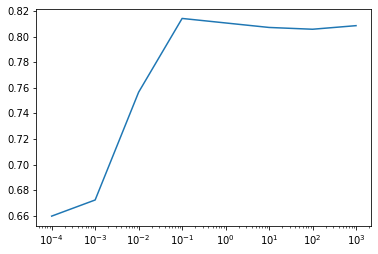

In [182]:
plt.plot([p['C'] for p in gscv.cv_results_['params']], gscv.cv_results_['mean_test_score'])
plt.xscale('log')

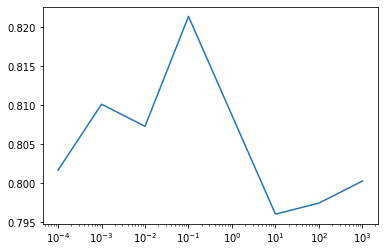

In [183]:
plt.plot([p['C'] for p in gscv_poly.cv_results_['params']], gscv_poly.cv_results_['mean_test_score'])
plt.xscale('log')

- 5-fold cross validationでパラメータ探索した結果は、validに合わせた結果と異なっていた
  - つまり先程の結果はvalidセットに依存していたものだといえる
- 共通の条件の比較では、2次の項をいれないモデルのほうが強い
- 2次の項をいれたものは過学習しやすく、正規化項では吸収しきれてないので、変数選択を行ってパラメータを減らさないといけなさそうだ
- もしくはより強いモデルが必要になる

## モデルを評価しよう

- ここまではAccuracyで評価してきたが、他にも様々な評価指標がある
- なにで評価するかはタスクによって変わる
- 今回は特にタスクが特殊じゃないのでAccuracyでよいけど、分類モデルだとConfusion Matrix, ROC Curveあたりを使ったりする

In [187]:
confusion_matrix(y_train, gscv.best_estimator_.predict(X_train))

array([[385,  52],
       [ 84, 190]])

In [186]:
confusion_matrix(y_valid, gscv.best_estimator_.predict(X_valid))

array([[98, 14],
       [24, 42]])

In [188]:
confusion_matrix(y_train, gscv_poly.best_estimator_.predict(X_train_poly))

array([[399,  38],
       [ 75, 199]])

In [189]:
confusion_matrix(y_valid, gscv_poly.best_estimator_.predict(X_valid_poly))

array([[97, 15],
       [24, 42]])

- 二値分類におけるConfusion MatrixはTP, TN, FP, FNの4象限で評価をする
   - TP: 正解したものでPositive (正例)のもの
   - TN: 正解したものでNegative (負例)のもの
   - FP, FN: 不正解のもの
- 多クラス分類だと、どのクラスをどのクラスとして予測したかという可視化になる

- この結果、Validの精度の違いは1サンプル分だけなので、ほぼ誤差の範囲、 validのデータの選ばれ方に依存なのではということがわかる

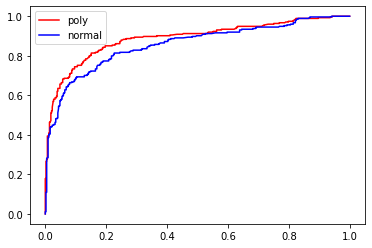

In [207]:
fpr, tpr, thresholds = roc_curve(y_train, gscv_poly.best_estimator_.predict_proba(X_train_poly)[:,1])
plt.plot(fpr, tpr, color='r', label='poly')
fpr, tpr, thresholds = roc_curve(y_train, gscv.best_estimator_.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr, color='b', label='normal')
plt.legend()

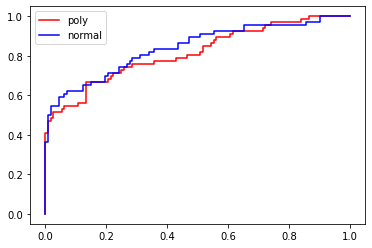

In [208]:
fpr, tpr, thresholds = roc_curve(y_valid, gscv_poly.best_estimator_.predict_proba(X_valid_poly)[:,1])
plt.plot(fpr, tpr, color='r', label='poly')
fpr, tpr, thresholds = roc_curve(y_valid, gscv.best_estimator_.predict_proba(X_valid)[:,1])
plt.plot(fpr, tpr, color='b', label='normal')
plt.legend()

- ROC曲線は、出力の確率値に対してしきい値を変えたときのTPとFPの関係をPlotしている
- TrainではPolyのものが全体としてよいが、ValidではPolyでないものが全体としてよい
- Confusion Matrixでは誤差程度といったが、少なくともこのValidの中では全体として悪いということがいえそう。
- より詳しく考察するならseed値変えてTrain ValidのSplitを複数回やるなどして頑健性をみるとよいのかもしれない